# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- **This homework must be completed individually.**

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.


Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import these libraries

In [2]:
import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from pandas.core import datetools
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the [Capital Bikeshare program](https://www.capitalbikeshare.com) in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



<div class='exercise'> <b> Question 1 [20pts]  Data pre-processing </b> </div>

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicollinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and **test** your code by producing `practice_y_train` and `practice_X_train`.

**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.



### Solutions 

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

In [3]:
# your code here
bikes_main = pd.read_csv('data/bikes_student.csv', index_col=['Unnamed: 0'])
bikes_main.head()

,dteday,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
5887,2011-09-07,19,0,0,1,0.64,0.5758,0.89,0.0000,14,...,0,0,1,0,0,0,1,0,0,9
10558,2012-03-21,1,1,0,1,0.52,0.5000,0.83,0.0896,4,...,0,0,1,0,0,0,0,0,0,3
14130,2012-08-16,23,1,0,1,0.70,0.6515,0.54,0.1045,58,...,0,0,0,1,0,0,0,0,0,8
2727,2011-04-28,13,0,0,1,0.62,0.5758,0.83,0.2985,18,...,0,0,0,1,0,0,1,0,0,4
8716,2012-01-04,0,1,0,1,0.08,0.0606,0.42,0.3284,0,...,0,0,1,0,0,0,0,0,0,1


In [4]:
bikes_train, bikes_val = train_test_split(bikes_main, test_size = 0.2, stratify=bikes_main['month'], random_state=90)
display(bikes_train.describe())
bikes_val.shape

,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.0,1000.00000
mean,11.319000,0.509000,0.027000,0.681000,0.492780,0.472546,0.639740,0.195421,35.627000,158.652000,...,0.143000,0.148000,0.162000,0.128000,0.12700,0.15000,0.280000,0.082000,0.0,6.53300
std,6.879431,0.500169,0.162164,0.466322,0.192935,0.171544,0.188386,0.125800,50.618337,159.684451,...,0.350248,0.355278,0.368635,0.334257,0.33314,0.35725,0.449224,0.274502,0.0,3.44133
min,0.000000,0.000000,0.000000,0.000000,0.040000,0.060600,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,1.00000
25%,5.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.500000,0.104500,3.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,4.00000
50%,11.000000,1.000000,0.000000,1.000000,0.500000,0.484800,0.650000,0.194000,15.000000,112.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,7.00000
75%,17.000000,1.000000,0.000000,1.000000,0.660000,0.621200,0.800000,0.253700,49.250000,233.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.0,10.00000
max,23.000000,1.000000,1.000000,1.000000,0.940000,0.909100,1.000000,0.850700,362.000000,810.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.0,12.00000


(250, 36)

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicolinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_y_train` and `practice_X_train`


In [5]:
# your code here
def Xy_dropcol(df, col_drop, response: list=['counts']): 
    practice_df = df.copy()
    y = practice_df[response]
    X = practice_df.drop(columns=col_drop)
    return(y, X)

response = ['counts']
col_drop = ['dteday', 'counts', 'registered', 'casual', 'workingday', 'month']
practice_y_train, practice_X_train = Xy_dropcol(df=bikes_train, response = response, col_drop=col_drop)
display(practice_y_train.describe())
display(practice_X_train.describe())

,counts
count,1000.000000
mean,194.279000
std,191.635042
min,1.000000
25%,35.000000
50%,136.500000
75%,287.250000
max,970.000000


,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.0
mean,11.319000,0.509000,0.027000,0.492780,0.472546,0.639740,0.195421,0.078000,0.085000,0.082000,...,0.248000,0.143000,0.148000,0.162000,0.128000,0.12700,0.15000,0.280000,0.082000,0.0
std,6.879431,0.500169,0.162164,0.192935,0.171544,0.188386,0.125800,0.268306,0.279021,0.274502,...,0.432068,0.350248,0.355278,0.368635,0.334257,0.33314,0.35725,0.449224,0.274502,0.0
min,0.000000,0.000000,0.000000,0.040000,0.060600,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
25%,5.000000,0.000000,0.000000,0.340000,0.333300,0.500000,0.104500,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
50%,11.000000,1.000000,0.000000,0.500000,0.484800,0.650000,0.194000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
75%,17.000000,1.000000,0.000000,0.660000,0.621200,0.800000,0.253700,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.0
max,23.000000,1.000000,1.000000,0.940000,0.909100,1.000000,0.850700,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.0


**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


In [6]:
# your code here
binary_columns = ['holiday', 'workingday', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']
non_binary = practice_X_train.columns.difference(binary_columns)
print(non_binary)

def scale_num(fit_df, trans_df, non_binary: list):
    df_scaled = trans_df.copy()
    scaler = StandardScaler().fit(fit_df[non_binary])
    df_scaled[non_binary] = pd.DataFrame(scaler.transform(df_scaled[non_binary]), index=df_scaled.index, columns=non_binary)
    return(df_scaled)

practice_X_train_scaled = scale_num(practice_X_train, practice_X_train, non_binary)
practice_X_train_scaled.describe()

Index(['atemp', 'hour', 'hum', 'temp', 'windspeed', 'year'], dtype='object')


,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.0
mean,-1.994516e-16,2.686740e-17,0.027000,3.019807e-17,-1.256772e-16,5.995204e-17,1.301181e-16,0.078000,0.085000,0.082000,...,0.248000,0.143000,0.148000,0.162000,0.128000,0.12700,0.15000,0.280000,0.082000,0.0
std,1.000500e+00,1.000500e+00,0.162164,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.268306,0.279021,0.274502,...,0.432068,0.350248,0.355278,0.368635,0.334257,0.33314,0.35725,0.449224,0.274502,0.0
min,-1.646163e+00,-1.018165e+00,0.000000,-2.347976e+00,-2.402605e+00,-3.397602e+00,-1.554205e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
25%,-9.189949e-01,-1.018165e+00,0.000000,-7.922693e-01,-8.121270e-01,-7.421467e-01,-7.231056e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
50%,-4.639332e-02,9.821591e-01,0.000000,3.744066e-02,7.147176e-02,5.448995e-02,-1.130295e-02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
75%,8.262083e-01,9.821591e-01,0.000000,8.671507e-01,8.670022e-01,8.511266e-01,4.634972e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.0
max,1.698810e+00,9.821591e-01,1.000000,2.319143e+00,2.546131e+00,1.913309e+00,5.211499e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.0


**Explanation for 'year':**
*Treating 'year' as a non-binary predictor and scaling it so as to easily interpret and compare its coefficient w.r.t. other scaled continuous predictors.*

**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with apropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with qudratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

In [7]:
# your code here
non_binary2 = practice_X_train.columns.difference(binary_columns+['year'])
def add_poly(df, poly_col: list = non_binary2,d: int=2):
    df_poly = df.copy()
    for i in poly_col:
        for j in range(2,d+1):
            col_name = str(i)+'^%s'%j
            df_poly[col_name] = df_poly[i]**j
    return(df_poly)
    
practice_X_train_poly = add_poly(practice_X_train_scaled, non_binary2, d=3)
display(practice_X_train_poly.head())

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,atemp^2,atemp^3,hour^2,hour^3,hum^2,hum^3,temp^2,temp^3,windspeed^2,windspeed^3
15762,1.698810,0.982159,0,0.244868,0.248775,0.479363,-0.723106,0,0,0,...,0.061889,0.015396,2.885955,4.902689,0.229789,0.110152,0.059960,0.014682,0.522882,-0.378099
4213,-0.046393,-1.018165,0,1.385719,1.132373,-1.538783,0.226495,0,0,0,...,1.282270,1.452008,0.002152,-0.000100,2.367854,-3.643615,1.920218,2.660884,0.051300,0.011619
14301,-1.355296,0.982159,0,0.867151,0.867002,0.266926,-1.554205,0,0,0,...,0.751693,0.651719,1.836827,-2.489443,0.071250,0.019018,0.751950,0.652054,2.415552,-3.754263
15900,-0.918995,0.982159,0,-0.999697,-0.988847,0.904236,-0.486103,0,0,0,...,0.977818,-0.966912,0.844552,-0.776139,0.817642,0.739341,0.999394,-0.999091,0.236296,-0.114864
14320,1.407943,0.982159,0,1.074578,1.043722,-0.157946,-0.248305,0,0,0,...,1.089356,1.136984,1.982303,2.790969,0.024947,-0.003940,1.154718,1.240835,0.061656,-0.015309


**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**


In [8]:
# your code here
month_day = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 
                'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
continuous = ['temp','atemp', 'hum', 'windspeed']

def add_interactions(df, col_list1: list=month_day, col_list2: list=continuous):    
    addto_df = df.copy()
    for i in col_list1:
        for j in col_list2:
            col_name = str(i)+'*'+str(j)
            addto_df[col_name] = addto_df[i]*addto_df[j]
    return(addto_df)

practice_X_train_poly_int = add_interactions(practice_X_train_poly, col_list1 = month_day, col_list2 = continuous)
display(practice_X_train_poly_int.columns)
practice_X_train_poly_int.head()

Index(['hour', 'year', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'Feb',
       'Mar', 'Apr',
       ...
       'Thu*hum', 'Thu*windspeed', 'Fri*temp', 'Fri*atemp', 'Fri*hum',
       'Fri*windspeed', 'Sat*temp', 'Sat*atemp', 'Sat*hum', 'Sat*windspeed'],
      dtype='object', length=108)

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,Thu*hum,Thu*windspeed,Fri*temp,Fri*atemp,Fri*hum,Fri*windspeed,Sat*temp,Sat*atemp,Sat*hum,Sat*windspeed
15762,1.698810,0.982159,0,0.244868,0.248775,0.479363,-0.723106,0,0,0,...,0.0,-0.0,0.000000,0.000000,0.000000,-0.000000,0.0,0.0,0.0,-0.0
4213,-0.046393,-1.018165,0,1.385719,1.132373,-1.538783,0.226495,0,0,0,...,-0.0,0.0,0.000000,0.000000,-0.000000,0.000000,0.0,0.0,-0.0,0.0
14301,-1.355296,0.982159,0,0.867151,0.867002,0.266926,-1.554205,0,0,0,...,0.0,-0.0,0.867151,0.867002,0.266926,-1.554205,0.0,0.0,0.0,-0.0
15900,-0.918995,0.982159,0,-0.999697,-0.988847,0.904236,-0.486103,0,0,0,...,0.0,-0.0,-0.000000,-0.000000,0.000000,-0.000000,-0.0,-0.0,0.0,-0.0
14320,1.407943,0.982159,0,1.074578,1.043722,-0.157946,-0.248305,0,0,0,...,-0.0,-0.0,1.074578,1.043722,-0.157946,-0.248305,0.0,0.0,-0.0,-0.0


**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [9]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 'workingday', 'month', 'dteday']):
    # drop bad_columns
    y_train, x_train_base = Xy_dropcol(train_df, col_drop=bad_columns, response = target_col)
    y_val, x_val_base = Xy_dropcol(val_df, col_drop=bad_columns, response = target_col)    
    binary = x_train_base.columns.difference(columns_forpoly+['year'])
    
    non_binary = x_train_base.columns.difference(binary)
    
    # scale non-binary columns
    x_train_scaled = scale_num(x_train_base, x_train_base, non_binary)
    x_val_scaled = scale_num(x_train_base, x_val_base, non_binary)
    
    # add polynomial terms
    x_train_poly = add_poly(x_train_scaled, poly_col=columns_forpoly, d=degree)
    x_val_poly = add_poly(x_val_scaled, poly_col=columns_forpoly, d=degree)
    
    # add interaction terms as specified
    month_day = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 
                'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    continuous = ['temp','atemp', 'hum', 'windspeed']
    x_train = add_interactions(x_train_poly, col_list1 = month_day, col_list2 = continuous)
    x_val = add_interactions(x_val_poly, col_list1 = month_day, col_list2 = continuous)   
    
    return x_train,y_train, x_val,y_val

In [10]:
# your code here
x3_train, y3_train, x3_val, y3_val = get_design_mats(bikes_train, bikes_val, degree = 3)
x3_train.shape, y3_train.shape, x3_val.shape, y3_val.shape

((1000, 108), (1000,), (250, 108), (250,))

**Note:**
*Scaling is done only on main effects of the continuous vairables viz. `temp`, `atemp`, `hum`,`windspeed`, `year` and `hour`  and the polynomial terms are generated using scaled variables. No scaling on interaction terms is performed either, since they are interactions between continuous and binary variables and the mean of these variables would be a false representative of actual mean within the particular subgroup (say `month` = `Feb`) - so standardization would skew the results. We get higher $R^2$ scores on the validation and test sets using this method and brings us closer to our goal of predicting the demand.*

<div class='exercise'> <b> Question 2 [20pts]: Regularization via Ridge </b></div>

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**2.4** Find the best-scoring degree and regularization combination.

**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

### Solutions 

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

R^2 scores on validation set:[0, 0.3333593549938876, 0.4505712434573198, 0.4614700094304718, 0.44511722289624744, 0.4770266976583981, 0.478535825911224, 0.5379013892004801, 0.5567008413667595] 


Text(0.5,1,'$R^2$ score for each degree')

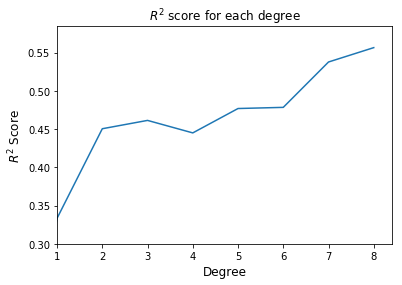

In [11]:
# your code here
degree = 8
reg_method = LinearRegression()
def getr2_val(train, val, method, degree: int=8):
    r2_val = [0]
    for i in range(1, degree+1):
        x_train, y_train, x_val, y_val = get_design_mats(bikes_train, bikes_val, degree = i)
        model = method.fit(x_train, y_train)
        r2_val.append(r2_score(y_val, model.predict(x_val)))
    return(r2_val)

r2_val = getr2_val(bikes_train, bikes_val, method = reg_method, degree= 8)

print('R^2 scores on validation set:%s '%r2_val)

plt.plot(r2_val)
plt.xlabel('Degree', fontsize = 12)
plt.ylabel('$R^2$ Score', fontsize = 12)
plt.xlim(xmin = 1)
plt.ylim(ymin = 0.3)
plt.title('$R^2$ score for each degree', fontsize = 12)

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?**

**Answer:**
*$R^2$ score shows a significant increase from $0.33$ at $degree = 1$ to $0.45$ at $degree = 2$. However, after that it plateaus out until from degree = 6 to degree = 7. Hence, the model with degree = 2 seems to be a good balance between bias and variance since the $R^2$ score is always going to increase as we add relevant variables.*

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 


In [12]:
# your code here
lamb = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
deg = 8
def scoring_table(train_df, val_df, fun=Ridge, lamb: list=lamb, degree: int=deg):
    r2_scores = dict()
    for i in range(len(lamb)):
        reg_method = fun(alpha=lamb[i])
        r2_scores['$alpha=$%s'%lamb[i]] = getr2_val(train_df, val_df, method = reg_method, degree=degree)
    r2_table = pd.DataFrame(r2_scores)[1:]
    for j in range(1,degree+1):
        r2_table.rename({j: '$degree=%s$'%j}, inplace=True)
    return(r2_table)

In [13]:
r2scores_ridge = scoring_table(bikes_train, bikes_val)
r2scores_ridge

,$alpha=$0.01,$alpha=$0.05,$alpha=$0.1,$alpha=$0.5,$alpha=$1,$alpha=$5,$alpha=$10,$alpha=$50,$alpha=$100
$degree=1$,0.334079,0.336303,0.338252,0.344601,0.347245,0.350852,0.350720,0.345421,0.340400
$degree=2$,0.451156,0.452777,0.454184,0.458863,0.460860,0.462742,0.461501,0.453643,0.448234
$degree=3$,0.462133,0.464616,0.466878,0.474055,0.477064,0.482930,0.484346,0.477066,0.464374
$degree=4$,0.445810,0.448139,0.450257,0.457269,0.460419,0.467707,0.470200,0.466792,0.458405
$degree=5$,0.477541,0.479419,0.481121,0.486543,0.488813,0.493436,0.494610,0.491686,0.487166
$degree=6$,0.479001,0.480442,0.481841,0.487837,0.491471,0.499539,0.501450,0.500695,0.496005
$degree=7$,0.538235,0.538780,0.539033,0.537512,0.534090,0.518093,0.511204,0.498667,0.492277
$degree=8$,0.556880,0.556861,0.556306,0.548498,0.539885,0.514831,0.508011,0.500281,0.497137


**2.4** Find the best-scoring degree and regularization combination.

In [14]:
idmax_deg = r2scores_ridge.stack().idxmax()[0][-2]
idmax_alpha = r2scores_ridge.stack().idxmax()[1][-4:]
max_r2 = r2scores_ridge.stack().max()
print('Max R^2 score combination on validation set: Degree = %s, Lambda = %s'%(idmax_deg, idmax_alpha), '\nMax R^2 value on validation set: %s'%max_r2)

Max R^2 score combination on validation set: Degree = 8, Lambda = 0.01 
Max R^2 value on validation set: 0.5568797750209158


**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset `data/bikes_test.csv`, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

In [15]:
# your code here
bikes_test = pd.read_csv('data/bikes_test.csv', index_col=['Unnamed: 0'])

degree=8
x_train_best, y_train_best, x_test_best, y_test_best = get_design_mats(bikes_train, bikes_test, degree=degree)
x_train_best.shape, y_train_best.shape, x_test_best.shape, y_test_best.shape

((1000, 133), (1000,), (1250, 133), (1250,))

In [16]:
# your code here
alpha = 0.01

reg_ridge = Ridge(alpha)
ridge_model = reg_ridge.fit(x_train_best, y_train_best)

print('R^2 score on the test set: %s'%r2_score(y_test_best, ridge_model.predict(x_test_best)))

R^2 score on the test set: 0.5668964072043827


**Answer:**
*The $R^2$ score for our selected model on the test set is very close but slightly higher than that on the validation set.*

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

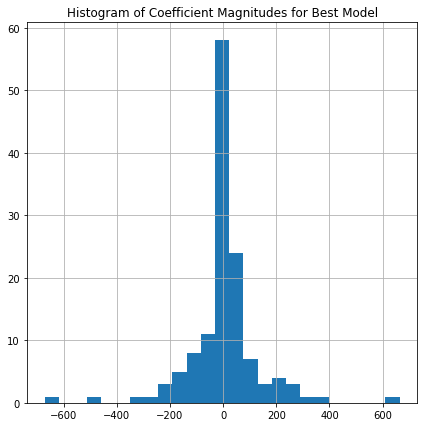

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.hist(ridge_model.coef_, bins = 25)
ax.set_title('Histogram of Coefficient Magnitudes for Best Model', fontsize = 12)
ax.grid(True)

**Answer:**
*Our model's test score in Question 2.5 is actually slightly better than the validation score found in 2.4. Which means in addition to taking care of overfitting via regularization, we also made sure that the train, validation and test sets all have equally distributed data points. However, we can see that the model we selected has the lowest penalizing term and highest degree with most of the coefficients very close to zero (see above plot). This is expected in a ridge model as convergence takes higher values of $lambda$. Thus we might still have a good model if we increase the penalizing factor, as seen for $degree=8$, $alpha=0.1$.*

<div class='exercise'><b> Question 3 [20pts]: Comparing Ridge, Lasso, and OLS </b> </div>

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Solutions

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

In [18]:
#your code here
x1_main, y1_main, x1_test, y1_test = get_design_mats(bikes_main, bikes_test, degree=1)
x1_main.shape, y1_main.shape

((1250, 98), (1250,))

In [19]:
# OLS
x1_main_ca = sm.add_constant(x1_main)
x1_test_ca = sm.add_constant(x1_test)
OLS = sm.OLS(y1_main, x1_main_ca)
OLSModel = OLS.fit()
OLS_coef = OLSModel.params[1:]
display(OLSModel.mse_resid)
r2_ols = r2_score(y1_test, OLSModel.predict(x1_test_ca))
print('R^2 score on test set using OLS: %s'%r2_ols)

21491.84344299904

R^2 score on test set using OLS: 0.3587440004499093


In [20]:
# Regularization parameters
lamb = (0.1,0.5,1,5,10,50,100)

# RidgeCV
for n in (10, 5):
    folds = KFold(n, random_state=42, shuffle=True)
    ridgeCV_obj = RidgeCV(alphas = lamb, cv = folds)
    ridgeCV_model = ridgeCV_obj.fit(x1_main, y1_main)
    r2 = r2_score(y1_test, ridgeCV_model.predict(x1_test))
    cvscore = cross_val_score(estimator=ridgeCV_model, X=x1_main, y=y1_main, cv=folds)
    print('CV scores on train set using RidgeCV with %s fold CV: %s'%(n, cvscore))
    print('R^2 score on test set using RidgeCV with %s fold CV: %s'%(n, r2))
    
folds10 = KFold(10, random_state=42, shuffle=True)
ridgeCV_obj = RidgeCV(alphas = lamb, cv = folds10)
ridgeCV_model = ridgeCV_obj.fit(x1_main, y1_main)
print("\nBest model searched using LassoCV:\nalpha = {}\nintercept = {}\nbetas = {}".format(ridgeCV_model.alpha_,
                                                                    ridgeCV_model.intercept_,
                                                                    ridgeCV_model.coef_                
                                                                                 )
     )

CV scores on train set using RidgeCV with 10 fold CV: [0.3274923  0.45357808 0.32046252 0.41772578 0.4450766  0.41694038
 0.2753361  0.41903317 0.35319947 0.40662009]
R^2 score on test set using RidgeCV with 10 fold CV: 0.3918975364632028
CV scores on train set using RidgeCV with 5 fold CV: [0.39952035 0.37170597 0.43220054 0.37251577 0.38355792]
R^2 score on test set using RidgeCV with 5 fold CV: 0.3918975364632028

Best model searched using LassoCV:
alpha = 50
intercept = 180.48369136843326
betas = [ 47.65677221  38.80897078 -10.1666682   43.2109219   36.75831181
 -34.25799254   4.7615861   -9.06709877  21.05940652  -7.2729909
   2.04915374  -8.39007321  -1.7032997   -3.78605945   5.17608252
  24.28855222   5.19056724  10.55602159  11.087458     7.66686457
  31.12051082  -4.89526129 -11.77593044   7.622741    20.66381567
  -5.01077001   0.66194969  14.289635   -33.27195074   0.
  -9.04818151 -11.37697288  35.20268402  -3.09048821  10.96861638
  12.04805496   3.66530312  12.58019117  

In [21]:
# LassoCV
for n in (10, 5):
    folds = KFold(n, random_state=42, shuffle=True)
    lassoCV_obj = LassoCV(alphas = lamb, cv = folds, max_iter=100000)
    lassoCV_model = lassoCV_obj.fit(x1_main, y1_main)
    r2 = r2_score(y1_test, lassoCV_model.predict(x1_test))
    cvscore = cross_val_score(estimator=lassoCV_model, X=x1_main, y=y1_main, cv=folds)
    print('CV scores on train set using LassoCV with %s fold CV: %s'%(n, cvscore))
    print('R^2 score on test set using LassoCV with %s fold CV: %s'%(n, r2))
    

folds10 = KFold(10, random_state=42, shuffle=True)
lassoCV_obj = LassoCV(alphas = lamb, cv = folds10, max_iter=100000)
lassoCV_model = lassoCV_obj.fit(x1_main, y1_main)
print("\nBest model searched using LassoCV:\nalpha = {}\nintercept = {}\nbetas = {}".format(lassoCV_model.alpha_,
                                                                    lassoCV_model.intercept_,
                                                                    lassoCV_model.coef_
                                                                    )
     )

CV scores on train set using LassoCV with 10 fold CV: [0.32426598 0.46615452 0.32243724 0.3985036  0.45136585 0.40906558
 0.27523249 0.41245293 0.34352676 0.38561116]
R^2 score on test set using LassoCV with 10 fold CV: 0.3809626095108961
CV scores on train set using LassoCV with 5 fold CV: [0.40965853 0.35958897 0.43044211 0.37020605 0.37075409]
R^2 score on test set using LassoCV with 5 fold CV: 0.3809626095108961

Best model searched using LassoCV:
alpha = 0.5
intercept = 177.498425346549
betas = [ 49.07943306  38.58377783  -7.81318438  69.88304062  11.44529282
 -35.93672142   0.94055876  -0.          35.02732734  -0.
   0.          -0.          -0.          -0.           0.
  29.65451081   0.          17.13006325   8.454327    10.64851592
  38.62479872  -1.71364132  -9.82089364   8.17475278  24.92738443
  -2.79943166   0.          11.77280807 -49.28309082   0.
  -0.         -17.05658486  45.50434255   0.           0.
  30.99877538   0.          11.49279574   0.           0.
  -1.52

**Note:**
*A lot of the coefficients are turned to zero in LassoCV without affecting the test set $R^2$ score too much compared to RidgeCV. However, for RidgeCV there are many variables very close to zero with $R^2$ almost similar to that for LassoCV. Thus, we can safely use the best model found by LassoCV for variable selection.*

*Also, note that we get a better test set $R^2$ using the regularization methods as compared to `OLS`.*


**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

Text(0.5,0.98,'Histograms of Coefficients Using Different Models')

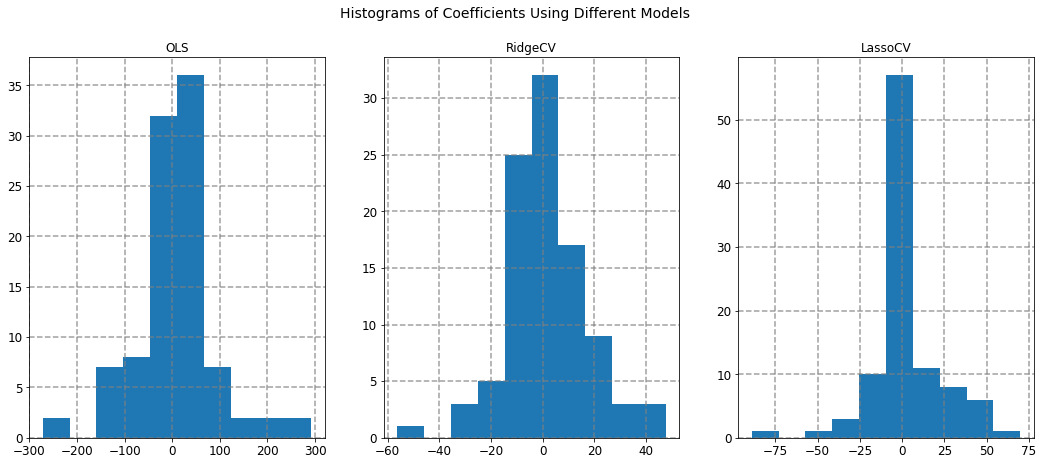

In [22]:
# your code here
fig1, ax1 = plt.subplots(1, 3, figsize=(18,7))
ax1[0].hist(OLS_coef)
ax1[0].tick_params(labelsize = 12)
ax1[0].set_title('OLS', fontsize = 12)
ax1[0].grid(True, lw = 1.5, ls = '--', color ='grey', alpha = 0.75)

ax1[1].hist(ridgeCV_obj.coef_)
ax1[1].tick_params(labelsize = 12)
ax1[1].set_title('RidgeCV', fontsize = 12)
ax1[1].grid(True, lw = 1.5, ls = '--', color ='grey', alpha = 0.75)

ax1[2].hist(lassoCV_obj.coef_)
ax1[2].tick_params(labelsize = 12)
ax1[2].set_title('LassoCV', fontsize = 12)
ax1[2].grid(True, lw = 1.5, ls = '--', color ='grey', alpha = 0.75)

fig1.suptitle('Histograms of Coefficients Using Different Models', fontsize = 14)

**Answer:**
*We can see that distribution of the coefficients for all the models are centered at zero. `OLS` has widest confidence interval, then comes `RidgeCV`, then `LassoCV`. In other words, the coefficients have least magnitudes in `LassoCV`, slightly higher in `RidgeCV` and the highest in `OLS`. It also demonstrates the fact that the rate at which the variables are converged to zero is in the following order (lowest to highest) - `OLS` (no convergence, since no penalizing factor), `RidgeCV`, `LassoCV`.*


**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

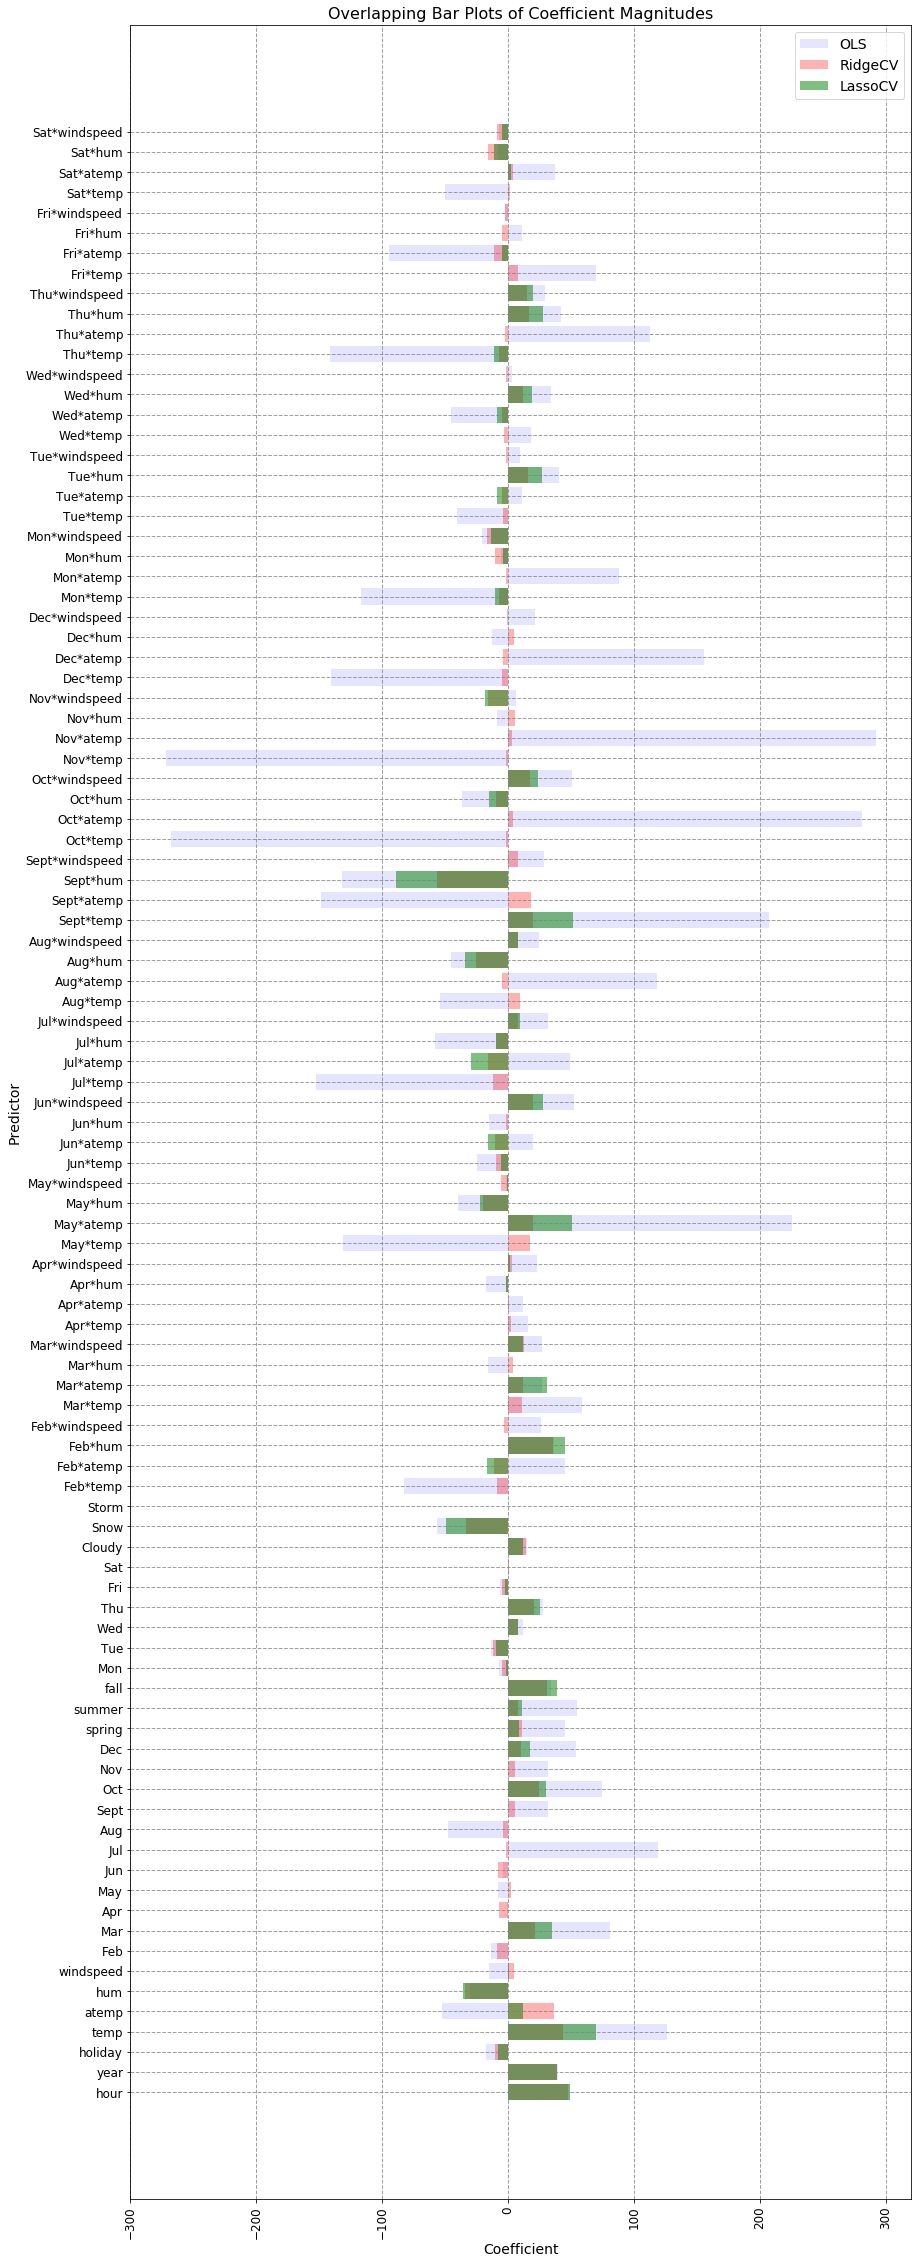

In [23]:
# your code here
fig2, ax2 = plt.subplots(1, 1, figsize = (14,40))
ax2.barh(x1_main.columns, OLS_coef, label='OLS', color='blue', alpha=0.1)
ax2.barh(x1_main.columns, ridgeCV_obj.coef_, label='RidgeCV', color='red', alpha=0.3)
ax2.barh(x1_main.columns, lassoCV_obj.coef_, label='LassoCV', color='green', alpha=0.5)
ax2.set_xlabel('Coefficient', fontsize = 14)
ax2.set_ylabel('Predictor', fontsize = 14)
ax2.set_title('Overlapping Bar Plots of Coefficient Magnitudes', fontsize = 16)
ax2.grid(which='major', lw = 1, ls = '--', color ='grey', alpha = 0.75)
ax2.legend(loc='best', fontsize = 14)
ax2.tick_params(axis = 'x', labelsize = 12, labelrotation = 90)
ax2.tick_params(axis = 'y', labelsize = 12)

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

In [24]:
# Get non-zero betas from LassoCV
betas_df = pd.DataFrame(lassoCV_model.coef_, index = x1_main.columns, columns = ['betas'])
betas_sig = betas_df[betas_df['betas']!=0].index
x1_main_sig = sm.add_constant(x1_main[betas_sig])
x1_test_sig = sm.add_constant(x1_test[betas_sig])

# Fit an OLS using non-zero betas
OLS_sig = sm.OLS(y1_main,x1_main_sig)
OLSModel_sig = OLS_sig.fit()
r2_sig = r2_score(y1_test, OLSModel_sig.predict(x1_test_sig))
print('R^2 score on test using non-zero betas from LassoCV: %s'%r2_sig)

mse_sig = OLSModel_sig.mse_resid
print('MSE on test using non-zero betas from LassoCV: %s'%mse_sig)

display(OLSModel_sig.summary())

R^2 score on test using non-zero betas from LassoCV: 0.36533840396783224
MSE on test using non-zero betas from LassoCV: 21087.995177634577


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     17.79
Date:                Wed, 17 Oct 2018   Prob (F-statistic):          5.19e-120
Time:                        13:04:47   Log-Likelihood:                -7967.3
No. Observations:                1250   AIC:                         1.605e+04
Df Residuals:                    1193   BIC:                         1.634e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           151.1361     17.174      8.800      0.000     117.441     184.831
hour             48.8566      4.487     10.890      0.000      40.054      57.659
year             38.3401      4.330      8.855      0.000      29.845      46.835
holiday         -20.7775     25.631     -0.811      0.418     -71.064      29.509
temp             64.8831     30.924      2.098      0.036       4.211     125.555
atemp            22.6532     30.302      0.748      0.455     -36.798      82.104
hum             -37.3759     10.237     -3.651      0.000     -57.459     -17.292
windspeed         2.4752      8.747      0.283      0.777     -14.686      19.636
Mar              72.0615     22.549      3.196      0.001      27.821     116.301
Oct              57.5547     21.040      2.735      0.006      16.274      98.835
Dec              31.3500     17.462      1.795      0.073      -2.909      65.609
spring           33.9096     17.047      1.989      0.047       0.464      67.355
summer           56.0200     22.900      2.446      0.015      11.092     100.948
fall             53.6282     16.281      3.294      0.001      21.685      85.571
Mon              -7.4669     14.210     -0.525      0.599     -35.346      20.413
Tue             -16.4876     13.803     -1.195      0.233     -43.568      10.593
Wed               9.0439     13.349      0.678      0.498     -17.145      35.233
Thu              24.9906     13.885      1.800      0.072      -2.251      52.232
Fri              -7.2949     14.128     -0.516      0.606     -35.014      20.424
Cloudy           16.1869     10.194      1.588      0.113      -3.814      36.188
Snow            -54.2807     17.201     -3.156      0.002     -88.029     -20.532
Feb*atemp       -31.2415     15.295     -2.043      0.041     -61.251      -1.233
Feb*hum          45.0074     16.132      2.790      0.005      13.358      76.657
Mar*atemp        68.2307     25.687      2.656      0.008      17.834     118.627
Mar*windspeed    18.0661     15.575      1.160      0.246     -12.491      48.623
Apr*hum          -8.6394     14.526     -0.595      0.552     -37.139      19.860
Apr*windspeed     9.6436     15.339      0.629      0.530     -20.450      39.737
May*atemp        79.9654     24.786      3.226      0.001      31.337     128.594
May*hum         -31.7726     17.936     -1.771      0.077     -66.962       3.417
May*windspeed   -12.8009     19.483     -0.657      0.511     -51.026      25.424
Jun*temp          3.1952    114.728      0.028      0.978    -221.895     228.286
Jun*atemp       -24.7493    118.292     -0.209      0.834    -256.832     207.333
Jun*windspeed    41.1063     18.895      2.176      0.030       4.035      78.178
Jul*atemp       -33.7086     15.026     -2.243      0.025     -63.189      -4.229
Jul*hum         -23.8067     19.732     -1.207   

**Answer:**
*We see that the signs of the coefficients for `atemp` (including its interaction terms) using OLS are opposite to that for the redularization methods (RidgeCV and LassoCV). This points to difference in approaches between OLS and regularized methods for handling correlated variables.*
*Also observe that we get a slightly better $MSE$ and $R^2$ using only those terms that are not converged to zero by the best model found using `LassoCV`.*

<div class='exercise'> <b> Question 4 [20 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**4.1** Reflect back on the `get_design_mats` function you built. Writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**Answer:**
*Yes, the `get_design_mats` function was useful in performing identical set of data pre-processing operations on multiple data sets. Copy/pasting the code each time would require us to create new data frames for each data set at each pre-processing step, which could be cumbersome to track and could have created issues in case repeated names were used. It's always wise to create a customized function that ties together all the requried pre-processing for the data set in use, so that it can be re-used thorughout the analysis.*

**4.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting features for the model?

**Answer:**
*The biggest benefit of doing `Ridge` or `Lasso` is that we get a fairly balanced model in much less number of steps as compared to forward selection where each feature has to be selected by comparing all possible models at that step. By setting a specific polynomial degree we would lose out on other potential significant variables/models that we could have found with different degrees. It's okay to set the degree after investigating where the test set error/$R^2$ score plataeus. One main dis-advantage of regularization is that it is difficult to do statistical inferencing ($R^2$, MSE, etc.) unlike the stepwise approach.*

** 4.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 3, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**Answer:**
*From the perspective of a purely predictive goal, the model interpretability might not be as important since the goal is to find a function with minimum error. However, we do need to pay attention to the coefficients as they might suggest various things happening in the data. One major observation from Question 3 is that we can see opposite signs of coefficients for `OLS` model versus regularized models. This is due to multi-collinearity, so even if interpretability might not be of high importance, paying attention to some statistical measures/parameters would be helpful in pointing out various issues in the data.*


**4.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work

**Answer:**
*We came closest to predicting the weekly demand with $degree = 8$ and $alpha = 0.01$, however, we should try a similar approach using `LassoCV` and create a table of test set $R^2$ to see what we get. As in Question 3.1, we can see that `LassoCV` and `RidgeCV` perform almost the same but a lot of coefficients are turned off in `LassoCV`, which probably means that we could still get a simliar performing model as found in 2.3 with much less variables.*
*To summarize, the best approach would be:*
* Start with a data set of upto $degree = 8$ polynomial terms.
* Perform `OLS`, `RidgeCV` and `LassoCV` with various $lambda$ values to find correlated and less important variables (or variables turned to 0 by LassoCV).
* Then fit an `OLS`(excluding the variables in the previous step) to get the statistical inferencing of the new model.